In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
from pathlib import Path
from collections import Counter

from plotting_functions import *
import IPython.display as ipd

In [3]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate) # d: amount of time btw smples
    Y = abs(np.fft.rfft(y)/n) # magnitude and normalize by length of signal
    
    return (Y, freq) # magnitude & freq

In [6]:
! ls

Audio processing techniques.ipynb  imgs			  README.md
clean				   modeling.ipynb	  runs
data				   plotting_functions.py  simple_data
data visualization.ipynb	   pre-processing.ipynb
environment.yml			   __pycache__


In [7]:
PATH = Path('./')
TRAIN_FILES = Path('./simple_data/')

Let's look at the curated part of the sounds first. Our first step will be to uncompress the files and look at how the information is given.

```
$ unzip $PATH/train_curated.zip
```

In [13]:
train_df = pd.read_csv(PATH/'instruments.csv')
df = train_df
df.head()

,fname,label
0,5388d14d.wav,Saxophone
1,c685f05f.wav,Saxophone
2,36d20ab5.wav,Saxophone
3,d6665734.wav,Saxophone
4,7352e28f.wav,Saxophone


In [14]:
classes = df.label.unique()

In [15]:
f'There are {len(classes)} # labels in {len(df)} observations'

'There are 10 # labels in 300 observations'

In [16]:
df.set_index('fname', inplace=True)

In [17]:
ipd.Audio(str(TRAIN_FILES/df.index[0]))

# Reading Audio scipy.io.wavefile

In [18]:
file_path = TRAIN_FILES/train_df.index[0]
file_path

PosixPath('simple_data/5388d14d.wav')

In [19]:
rate, signal = wavfile.read(file_path)

In [20]:
signal, rate

(array([-189, -245, -275, ...,    1,   -1,   -1], dtype=int16), 44100)

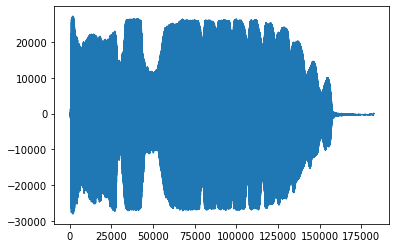

In [21]:
plt.plot(signal)
plt.show()

Do it for all the audio

In [22]:
for f in train_df.index:
    rate, signal = wavfile.read(TRAIN_FILES/f)
    train_df.at[f, 'length'] = signal.shape[0]/rate

In [24]:
len_class_mean = train_df.groupby(['label'])['length'].mean()
len_class_mean

label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64

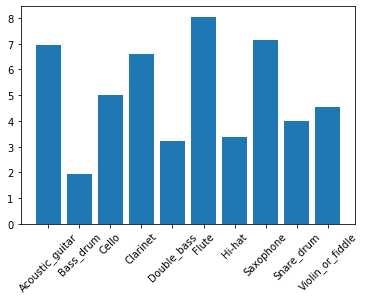

In [25]:
plt.bar(x=len_class_mean.index[:20], height=len_class_mean[:20])
plt.xticks(rotation=45)
plt.show()

# Reading Audio with librosa

**NOTE**: `scipy.io.wavefile.read` automatically detects the rate unlike `librosa.load` where you have to specify it via `sr` argument.

In [26]:
# ! mkdir data/samples
# ! mkdir data/clean

In [27]:
train_df.head()

,label,length
fname,,
5388d14d.wav,Saxophone,4.14
c685f05f.wav,Saxophone,1.54
36d20ab5.wav,Saxophone,4.90
d6665734.wav,Saxophone,10.50
7352e28f.wav,Saxophone,6.24


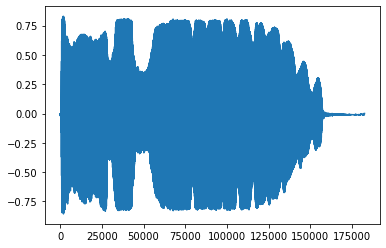

In [28]:
signal, rate = librosa.load(TRAIN_FILES/train_df.index[0], sr=44100)
plt.plot(signal)
plt.show()

**NOTE:** Observe that `librosa` and `scipy` read the signal with different scales. Here we observe that `magnitude(librosa) << magnitude(scipy)`

In [29]:
Y, freq = calc_fft(signal, rate) # We need signal and spacing (rate)
Y.shape, freq.shape

((91288,), (91288,))

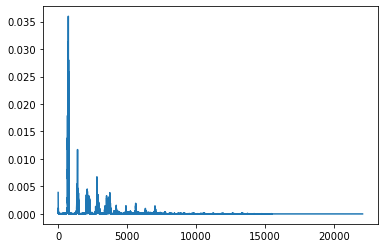

In [30]:
plt.plot(freq, Y)

In [50]:
# nfilters: std is 26, 
# nfft: we had a window size of 25 mlsec ie 1sec/40 ->
# -> Points falling in each window 44100/40=1102.5 sim 1103
bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
bank.shape # Filters, Frequency

(26, 99)

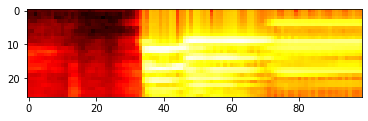

In [51]:
plt.imshow(bank, cmap='hot', interpolation='nearest')

In [52]:
mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T

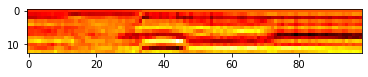

In [53]:
plt.imshow(mel, cmap='hot', interpolation='nearest')

In [35]:
def envelop(y, rate, threshold=.0005):
    '''
    Computes the mask of valid/non-valid signals based on the envelop.
    
    to compute the evelop we don't want to check individual values that fall
    but when a consecutive values fall --> Rolling windows. 
    
    y: List[int], rate, threshold=.0005
    '''
    mask = []
    y = pd.Series(y).apply(np.abs)
    
    # if more periods are needed we get NaN in the extremess.
    y_mean = y.rolling(window=rate//10,center=True, min_periods=1).mean() 
    
    for mean in y_mean:
        if mean > threshold: mask.append(True)
        else: mask.append(False)
            
    return mask

In [38]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = train_df[train_df.label == c].index[0]
    signal, rate = librosa.load(TRAIN_FILES/wav_file, sr=44100)
    mask = envelop(signal, rate, threshold=.0005)
    signal = signal[mask]
    signals[c] = signal
    
    # fast fourier transform: Returns Magnitude and freq.
    fft[c] = calc_fft(signal, rate) # We need signal and spacing (rate)
    
    # filter bank energies
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T # nfilters: std is 26, nfft: we had a window size of 25 mlsec ie 1sec/40 -> Points falling in each window 44100/40=1102.5 sim 1103
    fbank[c] = bank
    
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T # number of ceptrals that we keep after doing the discrete cosine transform on the filter bank energies. Tipically 1/2 thworn away so set it to 13.
    mfccs[c] = mel
    

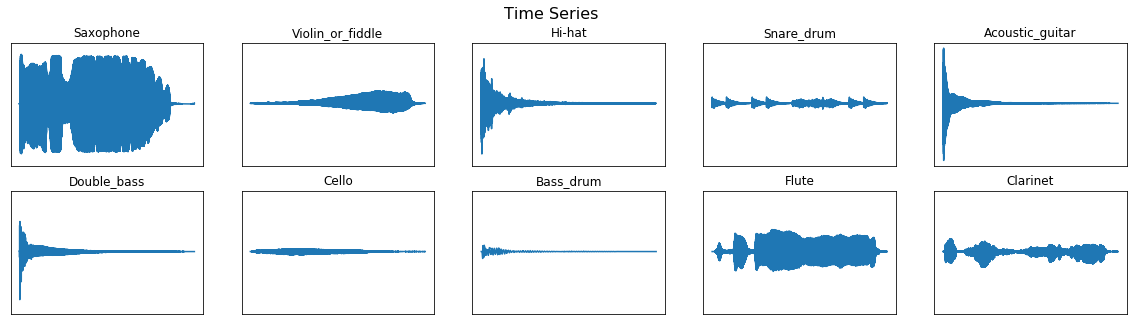

In [39]:
plot_signals(signals)

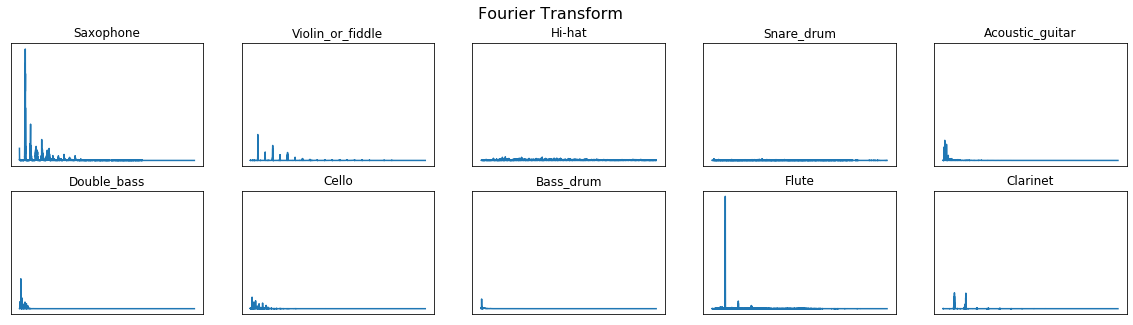

In [40]:
plot_fft(fft)

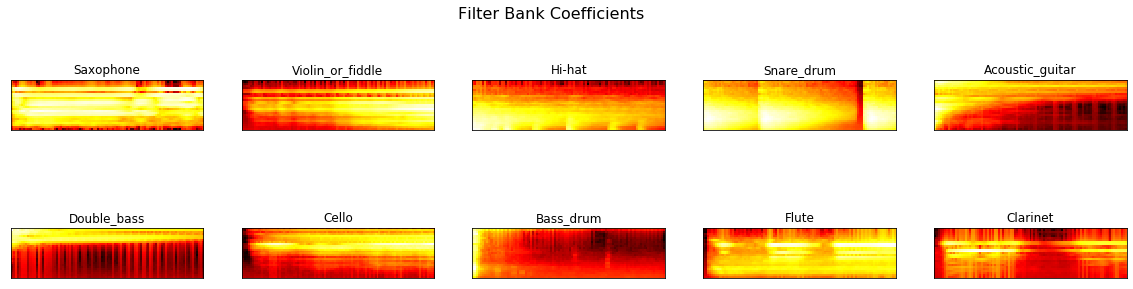

In [41]:
plot_fbank(fbank)

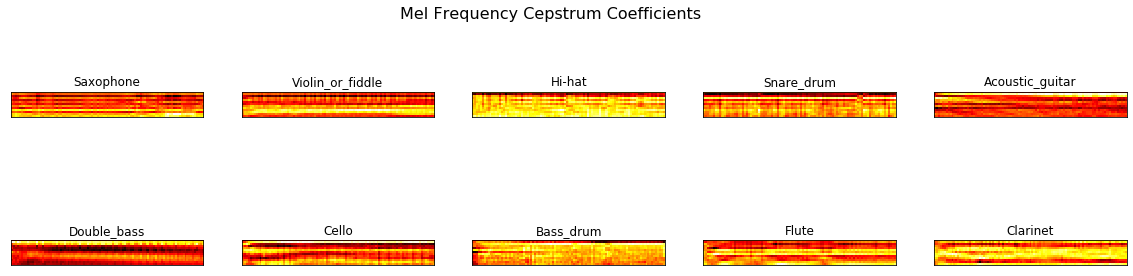

In [42]:
plot_mfccs(mfccs)

# Preprocessing, down-sampling & cleaning

In [43]:
train_df.reset_index(inplace=True)

In [44]:
# ! rm clean/*

if len(os.listdir('./clean/'))==0:
    for f in tqdm_notebook(train_df.fname):
        signal, rate = librosa.load(TRAIN_FILES/f, sr=16_000)
        mask = envelop(signal, rate, threshold=0.0005)
        wavfile.write(filename='./clean/'+f, rate=rate, data=signal[mask])